In [18]:
#import GPy
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#from xgboost import plot_importance
from numpy import loadtxt
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
import scikitplot as skplt
#from pycaret.classification import *

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import warnings

warnings.filterwarnings("ignore")  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt

%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

#from multiclass_classification import plot_posterior_predictions, colors

# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)
import warnings


warnings.warn("ignore")

In [5]:
# X_train = np.load('X_train_TREC_google_w2v.npy')
# y_train = np.load('y_train_TREC.npy').astype(int)
# X_test = np.load('X_test_TREC_google_w2v.npy')
# y_test = np.load('y_test_TREC.npy').astype(int)

In [6]:
# X_train = np.load('X_train_afr_manual_w2v.npy')
# y_train = np.load('y_train.npy').astype(int)
# X_test = np.load('X_test_afr_manual_w2v.npy')
# y_test = np.load('y_test.npy').astype(int)

In [7]:
X_train = np.load('X_train_afr_google_w2v.npy')
y_train = np.load('y_train.npy').astype(int)
X_test = np.load('X_test_afr_google_w2v.npy')
y_test = np.load('y_test.npy').astype(int)

In [8]:
y_train=y_train[:,np.newaxis]
y_test=y_test[:,np.newaxis]

In [9]:
data=(X_train,y_train)

## USing Squared Exponential Kernel


In [22]:
M=1000
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X_train[::M].copy()),
)

In [23]:
import warnings

warnings.filterwarnings("ignore")
warnings.warn("ignore")

In [24]:
%%time
rbf_training_loss_closure = rbf_m.training_loss_closure(data, compile=True)
rbf_elbo = lambda: -rbf_training_loss_closure().numpy()
print("RBF elbo before training: %.4e" % rbf_elbo())

RBF elbo before training: -2.4255e+05
CPU times: user 13.4 s, sys: 4.73 s, total: 18.1 s
Wall time: 11.6 s


In [25]:
import time

In [26]:
%%time
set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    rbf_training_loss_closure,
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": 100},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

### print accuracy 
train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy for {len(X_train[::M])} induced data points out of {len(X_train)} actual  data points")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.264 iter/s
Accuracy for 244 induced data points out of 243994 actual  data points
Train acc  : 89.72925563743371%
Test acc : 89.64943375188264%
RBF elbo after training: -6.2449e+04
CPU times: user 55min 37s, sys: 8min 25s, total: 1h 4min 3s
Wall time: 7min 5s


In [27]:

train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy with {len(X_train[::M])} induced data points ")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())

Accuracy with 244 induced data points 
Train acc  : 89.72925563743371%
Test acc : 89.64943375188264%
RBF elbo after training: -6.2449e+04


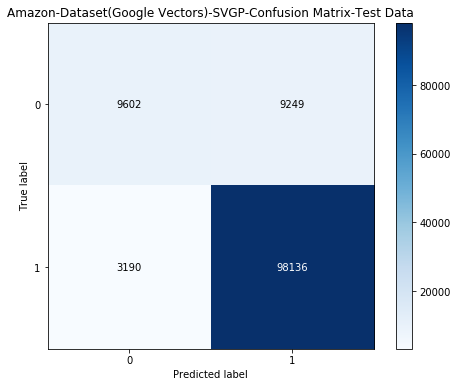

In [28]:
res = (rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_test, res)
plt.title("Amazon-Dataset(Google Vectors)-SVGP-Confusion Matrix-Test Data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

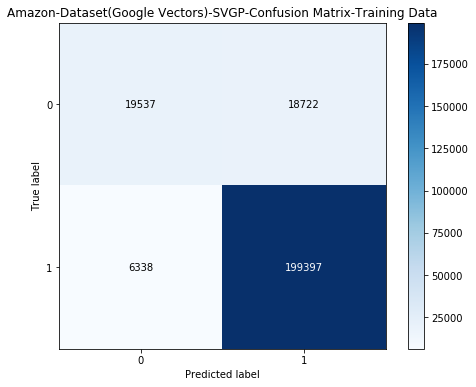

In [29]:
res_tr = (rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_train, res_tr)
plt.title("Amazon-Dataset(Google Vectors)-SVGP-Confusion Matrix-Training Data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

## Using centroids as induced points

In [10]:
# with centroids as inducing points 
from scipy import cluster
M = 1000
Z, distortion = cluster.vq.kmeans(X_train,M)

In [11]:
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(Z.copy()),
)

In [12]:
import warnings

warnings.filterwarnings("ignore")
warnings.warn("ignore")

In [13]:
%%time
rbf_training_loss_closure = rbf_m.training_loss_closure(data, compile=True)
rbf_elbo = lambda: -rbf_training_loss_closure().numpy()
print("RBF elbo before training: %.4e" % rbf_elbo())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
RBF elbo before training: -2.4255e+05
CPU times: user 47.4 s, sys: 8.2 s, total: 55.6 s
Wall time: 24.3 s


In [14]:
%%time
set_trainable(rbf_m.inducing_variable, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(
    rbf_training_loss_closure,
    variables=rbf_m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": 100},
)
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

### print accuracy 
train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy for {len(X_train[::M])} induced data points out of {len(X_train)} actual  data points")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.034 iter/s
Accuracy for 244 induced data points out of 243994 actual  data points
Train acc  : 90.02680393780174%
Test acc : 89.859956564068%
RBF elbo after training: -6.0904e+04
CPU times: user 4h 33min 12s, sys: 26min 46s, total: 4h 59min 59s
Wall time: 57min 13s


In [16]:
train_acc = np.mean((rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float") == y_train)
test_acc = np.mean((rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float") == y_test)
print(f"Accuracy with {M} induced data points ")
print(f"Train acc  : {train_acc * 100}%\nTest acc : {test_acc*100}%")
print("RBF elbo after training: %.4e" % rbf_elbo())

Accuracy with 1000 induced data points 
Train acc  : 90.02680393780174%
Test acc : 89.859956564068%
RBF elbo after training: -6.0904e+04


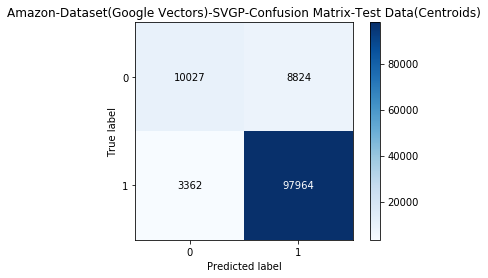

In [19]:
res = (rbf_m.predict_y(X_test)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_test, res)
plt.title("Amazon-Dataset(Google Vectors)-SVGP-Confusion Matrix-Test Data(Centroids)")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

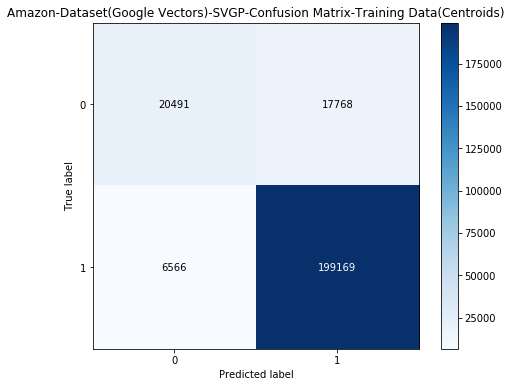

In [20]:
res_tr = (rbf_m.predict_y(X_train)[0] > 0.5).numpy().astype("float")
skplt.metrics.plot_confusion_matrix(y_train, res_tr)
plt.title("Amazon-Dataset(Google Vectors)-SVGP-Confusion Matrix-Training Data(Centroids)")
plt.rcParams['figure.figsize']=(8,6)
plt.show()